# Recommendation using embeddings and nearest neighbor search

In [1]:
import pandas as pd
import numpy as np

In [2]:
# DATASET_LINK="http://files.grouplens.org/datasets/movielens/ml-1m.zip"

In [3]:
# !wget -nc http://files.grouplens.org/datasets/movielens/ml-1m.zip
# !unzip -n ml-1m.zip

In [4]:
users = pd.read_csv(
    "ml-1m/users.dat",
    sep="::",
    names=["user_id", "sex", "age_group", "occupation", "zip_code"],
    encoding="ISO-8859-1",
    engine="python",
)

In [5]:
users.head()

,user_id,sex,age_group,occupation,zip_code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [6]:
ratings = pd.read_csv(
    "ml-1m/ratings.dat",
    sep="::",
    names=["user_id", "movie_id", "rating", "unix_timestamp"],
    encoding="ISO-8859-1",
    engine="python",
)
ratings.head()

,user_id,movie_id,rating,unix_timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [7]:
movies = pd.read_csv(
    "ml-1m/movies.dat",
    sep="::",
    names=["movie_id", "title", "genres"],
    encoding="ISO-8859-1",
    engine="python",
)
movies.head()

,movie_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [8]:
movies["combined"] = (
    "movie_id: " + movies.movie_id.astype(str)  + "; movie_title: " + movies.title.str.strip() + "; genres: " + movies.genres.str.strip()
)

In [9]:
movies.head()

,movie_id,title,genres,combined
0,1,Toy Story (1995),Animation|Children's|Comedy,movie_id: 1; movie_title: Toy Story (1995); ge...
1,2,Jumanji (1995),Adventure|Children's|Fantasy,movie_id: 2; movie_title: Jumanji (1995); genr...
2,3,Grumpier Old Men (1995),Comedy|Romance,movie_id: 3; movie_title: Grumpier Old Men (19...
3,4,Waiting to Exhale (1995),Comedy|Drama,movie_id: 4; movie_title: Waiting to Exhale (1...
4,5,Father of the Bride Part II (1995),Comedy,movie_id: 5; movie_title: Father of the Bride ...


### Movies Small Dataset

In [13]:
dataset = pd.read_csv('ml-100k/u.data', sep='\t',header=None,names=['user_id','movie_id','rating','timestamp'])
movie_id_1k = dataset['movie_id'].unique()

In [15]:
movie_id_1k = dataset['movie_id'].unique()
df = movies[movies['movie_id'].isin(movie_id_1k)]

In [17]:
df.head(2)

,movie_id,title,genres,combined
0,1,Toy Story (1995),Animation|Children's|Comedy,movie_id: 1; movie_title: Toy Story (1995); ge...
1,2,Jumanji (1995),Adventure|Children's|Fantasy,movie_id: 2; movie_title: Jumanji (1995); genr...
2,3,Grumpier Old Men (1995),Comedy|Romance,movie_id: 3; movie_title: Grumpier Old Men (19...
3,4,Waiting to Exhale (1995),Comedy|Drama,movie_id: 4; movie_title: Waiting to Exhale (1...
4,5,Father of the Bride Part II (1995),Comedy,movie_id: 5; movie_title: Father of the Bride ...
...,...,...,...,...
1632,1678,"Joy Luck Club, The (1993)",Drama,"movie_id: 1678; movie_title: Joy Luck Club, Th..."
1633,1679,Chairman of the Board (1998),Comedy,movie_id: 1679; movie_title: Chairman of the B...
1634,1680,Sliding Doors (1998),Drama|Romance,movie_id: 1680; movie_title: Sliding Doors (19...
1635,1681,Mortal Kombat: Annihilation (1997),Action|Adventure,movie_id: 1681; movie_title: Mortal Kombat: An...


In [42]:
import os
from openai import OpenAI
from dotenv import load_dotenv, find_dotenv

_ = load_dotenv(find_dotenv()) # read local .env file
openai.api_key = os.getenv('OPENAI_API_KEY')
client = OpenAI(api_key=openai.api_key)

### Create Movie Embeddings

In [43]:
from typing import List

def get_embedding(text: str, model="text-embedding-3-small") -> List[float]:
    text = text.replace("\n", " ")
    response = client.embeddings.create(input=[text], model=model)
    return response.data[0].embedding

In [45]:
df["embedding"] = df.combined.apply(lambda x: get_embedding(x, model=embedding_model))

/var/folders/7x/tfwsytqd3yjccjl53cm75j700000gn/T/ipykernel_12301/2237851020.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["embedding"] = df.combined.apply(lambda x: get_embedding(x, model=embedding_model))


In [46]:
# df.to_pickle("movielens_with_embedding.pickle")

In [47]:
df.to_csv("movielens_with_embedding.csv")

### Clustering

In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib
import matplotlib.pyplot as plt
from ast import literal_eval

In [2]:
df = pd.read_csv("movielens_with_embedding.csv")
df["embedding"] = df.embedding.apply(literal_eval).apply(np.array)

In [3]:
matrix = np.vstack(df.embedding.values)
matrix.shape

(1637, 1536)

In [4]:
n_clusters = 10
kmeans = KMeans(n_clusters=n_clusters, init="k-means++", random_state=42, n_init=10)
kmeans.fit(matrix)
df["cluster"] = kmeans.labels_

In [5]:
df["cluster"].value_counts()

cluster
2    360
4    267
3    201
7    166
1    151
6    141
8    122
5     84
9     82
0     63
Name: count, dtype: int64

Text(0.5, 1.0, 'Clusters identified visualized in language 2d using t-SNE')

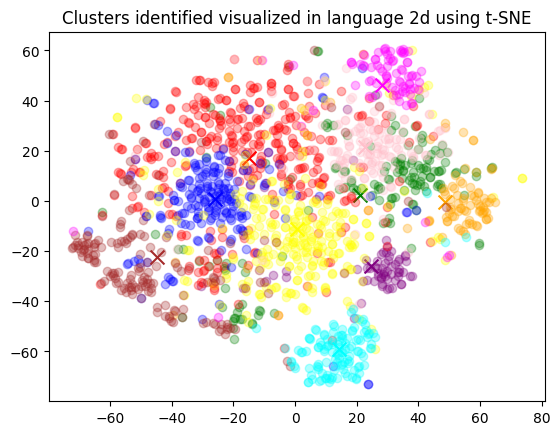

In [6]:
tsne = TSNE(
    n_components=2, perplexity=15, random_state=42, init="random", learning_rate=200
)
vis_dims2 = tsne.fit_transform(matrix)

x = [x for x, y in vis_dims2]
y = [y for x, y in vis_dims2]

for category, color in enumerate(["purple", "green", "red", "blue", "yellow", "orange", "pink", "brown", "cyan", "magenta"]):
    xs = np.array(x)[df.cluster == category]
    ys = np.array(y)[df.cluster == category]
    plt.scatter(xs, ys, color=color, alpha=0.3)

    avg_x = xs.mean()
    avg_y = ys.mean()

    plt.scatter(avg_x, avg_y, marker="x", color=color, s=100)
plt.title("Clusters identified visualized in language 2d using t-SNE")

In [7]:
import os
from openai import OpenAI
from dotenv import load_dotenv, find_dotenv

_ = load_dotenv(find_dotenv()) # read local .env file
openai_api_key = os.getenv('OPENAI_API_KEY')
client = OpenAI(api_key=openai_api_key)

In [11]:
model = "gpt-3.5-turbo"
for i in range(n_clusters):
    print(f"Cluster {i} Genres:\n")

    movies = "\n".join(
        df[df.cluster == i]
        .combined
        .sample(movies_per_cluster , random_state=42)
        .values
    )
    response = client.chat.completions.create(
        model=model,
        messages=[
            {"role": "user",
             "content": f'''We want to group these movies into meaningful clusters. 
                What do the following movies have in common?\n\nMovies:\n"""\n{movies}\n"""\n\nGenres:'''}
        ],
        temperature=0,
        max_tokens=100,
        top_p=1,
        frequency_penalty=0,
        presence_penalty=0,
    )
    print(response.choices[0].message.content.replace("\n", ""))
    print("\n")
    sample_cluster_rows = df[df.cluster == i].sample(movies_per_cluster, random_state=42)
    for j in range(movies_per_cluster):
        print(sample_cluster_rows.title.values[j], end=", ")
        print(sample_cluster_rows.genres.values[j], end="\n")

    print("-" * 100)
    print("\n")

Cluster 0 Genres:

The commonality among these movies is that they all belong to the genre of Documentary.


Year of the Horse (1997), Documentary
Fire on the Mountain (1996), Documentary
Across the Sea of Time (1995), Documentary
When We Were Kings (1996), Documentary
Jupiter's Wife (1994), Documentary
----------------------------------------------------------------------------------------------------


Cluster 1 Genres:

The common theme among these movies is that they all fall under the genres of Action and Adventure. Some of them also include elements of Thriller and Mystery.


Mission: Impossible (1996), Action|Adventure|Mystery
Crimson Tide (1995), Drama|Thriller|War
Quest, The (1996), Action|Adventure
Substitute, The (1996), Action
Air Force One (1997), Action|Thriller
----------------------------------------------------------------------------------------------------


Cluster 2 Genres:

All of the movies listed have the genre "Drama" in common.


Robin Hood: Prince of Thieves 

In [18]:
cluster = 8
print(f"Cluster {cluster } Genres:\n")

movies = "\n".join(
    df[df.cluster == cluster ]
    .combined
    .sample(movies_per_cluster , random_state=42)
    .values
)
response = client.chat.completions.create(
    model=model,
    messages=[
        {"role": "user",
         "content": f'''We want to group these movies into meaningful clusters. 
            What do the following movies have in common?\n\nMovies:\n"""\n{movies}\n"""\n\nGenres:'''}
    ],
    temperature=0,
    max_tokens=100,
    top_p=1,
    frequency_penalty=0,
    presence_penalty=0,
)
print(response.choices[0].message.content.replace("\n", ""))
print("\n")
sample_cluster_rows = df[df.cluster ==cluster].sample(movies_per_cluster, random_state=42)
for j in range(movies_per_cluster):
    print(sample_cluster_rows.title.values[j], end=", ")
    print(sample_cluster_rows.genres.values[j], end="\n")

print("-" * 100)
print("\n")

Cluster 8 Genres:

These movies all have the genre of Children's in common.


Oliver & Company (1988), Animation|Children's
Tom and Huck (1995), Adventure|Children's
Flintstones, The (1994), Children's|Comedy
Harriet the Spy (1996), Children's|Comedy
Pocahontas (1995), Animation|Children's|Musical|Romance
----------------------------------------------------------------------------------------------------




### Recommend similar movies based on embeddings

To find similar articles, let's follow a three-step plan:
1. Get the similarity embeddings of all the movies
2. Calculate the distance between a source movie query and all other movies
3. Print out the movies closest to the source movie query within the clusters

In [19]:
query = df.iloc[0]['combined']
print(query)

movie_id: 1; movie_title: Toy Story (1995); genres: Animation|Children's|Comedy


In [13]:
from sklearn.metrics.pairwise import cosine_similarity

response = client.embeddings.create(input=[query], model="text-embedding-3-small")
query_embedding = response.data[0].embedding

df["similarity"] = df["embedding"].map(lambda x: cosine_similarity(np.array(x).reshape(1, -1), np.array(query_embedding).reshape(1, -1))[0][0])
df = df.sort_values(by="similarity", ascending=False).reset_index()

In [22]:
print(f"Source movie query - {query}")

k_nearest_neighbors = 2
indices_of_nearest_neighbors = df.index.tolist()
strings = df["combined"].tolist()
similarities = df["similarity"].tolist()
clusters = df["cluster"].tolist()
k_counter = 0
for i in indices_of_nearest_neighbors:
    if query == strings[i]:
        continue
    if k_counter >= k_nearest_neighbors:
        break
    k_counter += 1

    print(
        f"""
    --- Recommendation #{k_counter} (nearest neighbor {k_counter} of {k_nearest_neighbors}) ---
    Movies: {strings[i]}
    Similarity: {similarities[i]:0.3f}
    Clusters: {clusters[i]}
    """
    )

Source movie query - movie_id: 1; movie_title: Toy Story (1995); genres: Animation|Children's|Comedy

    --- Recommendation #1 (nearest neighbor 1 of 2) ---
    Movies: movie_id: 239; movie_title: Goofy Movie, A (1995); genres: Animation|Children's|Comedy|Romance
    Similarity: 0.714
    Clusters: 8
    

    --- Recommendation #2 (nearest neighbor 2 of 2) ---
    Movies: movie_id: 34; movie_title: Babe (1995); genres: Children's|Comedy|Drama
    Similarity: 0.696
    Clusters: 8
    
